# The Battle of Neighborhoods - Capstone project Warsaw flats

##### Import necessary packages

In [2]:
from bs4 import BeautifulSoup
from requests import get
import requests
import sqlite3
from sys import argv
import re
import pandas as pd
import numpy as np
import wikipedia as wp
from geopy.geocoders import Nominatim
from geopy.distance import great_circle
import folium
import json

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import seaborn as sns
from pandas.io.json import json_normalize 

from sklearn.cluster import KMeans

### 1. Scraping local website
##### Set URL address to local website with apartments ad

In [3]:
URL = 'https://www.olx.pl/nieruchomosci/mieszkania/wynajem/warszawa/'
flats = []

In [4]:
def parse_price(price):
    return float(price.replace(' ','').replace('zł','').replace(',','.'))

In [5]:
def parse_page(pageNumber):
    print(f'Processing......... Page number {pageNumber}')
    page = get(f'{URL}?page={pageNumber}')
    bs = BeautifulSoup(page.content, 'html.parser')
    
    for offer in bs.find_all('div', class_='offer-wrapper'):
        footer = offer.find('td', class_ = 'bottom-cell')
        test = footer.find('small', class_='breadcrumb').get_text().strip().split(',')
        if (len(test)>1):
            location = footer.find('small', class_='breadcrumb').get_text().strip().split(',')[1]
            title = offer.find('strong').get_text().strip()
            price = parse_price(offer.find('p',class_='price').get_text().strip())
            
            #Processing of the ads from the pageNumber 
            link = offer.find('a')
            #print(link['href'])
            URL2 = link['href']
            page2 = get(URL2)
            bs2 = BeautifulSoup(page2.content, 'html.parser')
            offer2 = bs2.find_all('div', class_='clr descriptioncontent marginbott20')
            offer_detail_names_ = bs2.find_all('span', class_='offer-details__name')
            offer_detail_values_ = bs2.find_all('strong', class_='offer-details__value')
                
            offer_detail_names=[]
            offer_detail_values=[]
            for i in offer_detail_names_:
                offer_detail_names.append(i.contents[0])
            for i in offer_detail_values_:
                offer_detail_values.append(i.contents[0])
                    
            if 'Powierzchnia' in offer_detail_names:    
                i = offer_detail_names.index('Powierzchnia') 
                size_ = offer_detail_values[i].string
                size_ = size_[:-2]
                if ',' in size_:
                    size_ = size_.replace(',','.')
                size = float(size_)
                
                
                i = offer_detail_names.index('Liczba pokoi')
                rooms_ = offer_detail_values[i].string
                if rooms_ == 'Kawalerka':
                    rooms = 1
                else:
                    rooms_ = rooms_[:-6]
                    rooms = int(re.search(r'\d+', rooms_).group(0))
                flats.append([location,size,rooms,price,round(price/size,2)])

In [11]:
for page in range (1,26):
    parse_page(page)

Processing......... Page number 1
Processing......... Page number 2
Processing......... Page number 3
Processing......... Page number 4
Processing......... Page number 5
Processing......... Page number 6
Processing......... Page number 7
Processing......... Page number 8
Processing......... Page number 9
Processing......... Page number 10
Processing......... Page number 11
Processing......... Page number 12
Processing......... Page number 13
Processing......... Page number 14
Processing......... Page number 15
Processing......... Page number 16
Processing......... Page number 17
Processing......... Page number 18
Processing......... Page number 19
Processing......... Page number 20
Processing......... Page number 21
Processing......... Page number 22
Processing......... Page number 23
Processing......... Page number 24
Processing......... Page number 25


In [12]:
column_names = ['District', 'Size m2', 'Rooms', 'Price' , 'Price/m2']
flatsOffers = pd.DataFrame(flats, columns=column_names)
flatsOffers.head()

,District,Size m2,Rooms,Price,Price/m2
0,Włochy,49.00,2,2500.0,51.02
1,Ursus,37.07,2,1800.0,48.56
2,Białołęka,37.00,2,2300.0,62.16
3,Bielany,88.00,4,3499.0,39.76
4,Wawer,130.00,3,3500.0,26.92


In [13]:
print('There are {} flats in the dataset'.format(flatsOffers.shape[0]))

There are 989 flats in the dataset


##### Save scraping data to csv

In [16]:
flatsOffers.to_csv('flatsOffers.csv',index=False) 

##### Load data from csv

In [6]:
flatsOffers = pd.read_csv("flatsOffers.csv") 

### 2 Cleaning and visualize data

In [7]:
flatsOffers.describe()

,Size m2,Rooms,Price,Price/m2
count,989.000000,989.000000,989.000000,989.000000
mean,41.970293,1.885743,2008.408493,50.581062
std,16.142255,0.729711,721.634052,14.015332
min,10.000000,1.000000,100.000000,1.640000
25%,31.000000,1.000000,1590.000000,41.670000
50%,40.000000,2.000000,1900.000000,49.900000
75%,50.000000,2.000000,2300.000000,58.140000
max,150.000000,4.000000,10100.000000,125.000000


In [8]:
flatsOffers.dtypes

District     object
Size m2     float64
Rooms         int64
Price       float64
Price/m2    float64
dtype: object

##### Remove rows with NA values

In [9]:
flatsOffers.dropna(subset=['District', 'Size m2', 'Rooms', 'Price' , 'Price/m2'], inplace=True)
print('There are {} flats in the dataset'.format(flatsOffers.shape[0]))

There are 989 flats in the dataset


##### Let's check how many apartments per room number there is in dataset

In [10]:
flatsOffers['Rooms'].value_counts()

2    516
1    304
3    147
4     22
Name: Rooms, dtype: int64

##### We can check the number of apartments per room number and number of apartments in each district

[Text(0, 0, ' Włochy'),
 Text(0, 0, ' Ursus'),
 Text(0, 0, ' Białołęka'),
 Text(0, 0, ' Bielany'),
 Text(0, 0, ' Wawer'),
 Text(0, 0, ' Mokotów'),
 Text(0, 0, ' Ursynów'),
 Text(0, 0, ' Wola'),
 Text(0, 0, ' Żoliborz'),
 Text(0, 0, ' Targówek'),
 Text(0, 0, ' Bemowo'),
 Text(0, 0, ' Wilanów'),
 Text(0, 0, ' Ochota'),
 Text(0, 0, ' Śródmieście'),
 Text(0, 0, ' Praga-Północ'),
 Text(0, 0, ' Praga-Południe'),
 Text(0, 0, ' Wesoła'),
 Text(0, 0, ' Rembertów')]

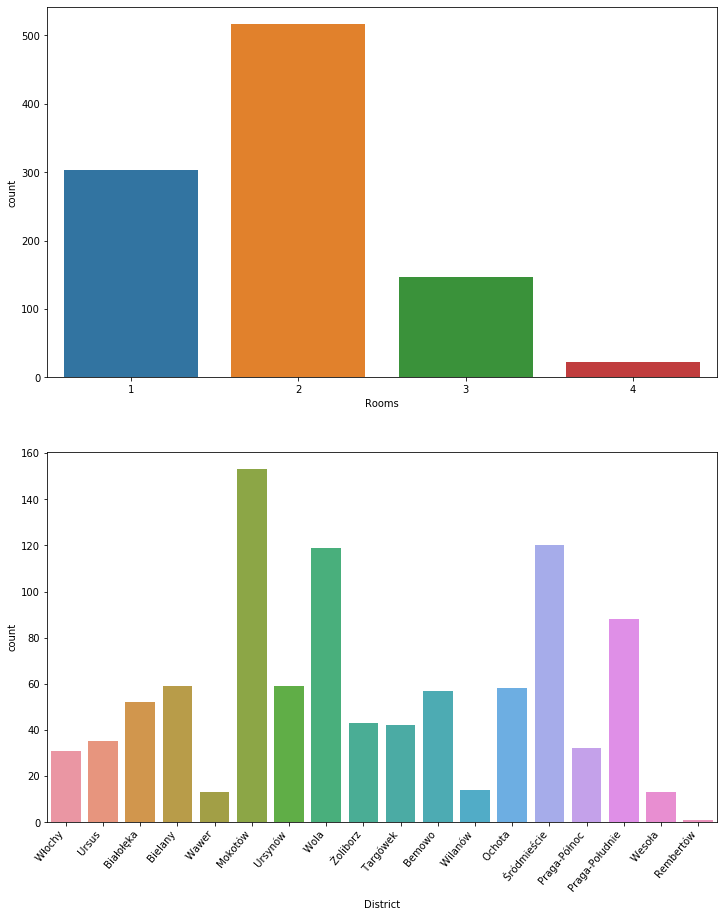

In [11]:
fig, ax =plt.subplots(2,1, figsize=(12,15))
sns.countplot(flatsOffers['Rooms'], ax=ax[0])
sns.countplot(flatsOffers['District'], ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=50, ha="right")

##### Plot the price

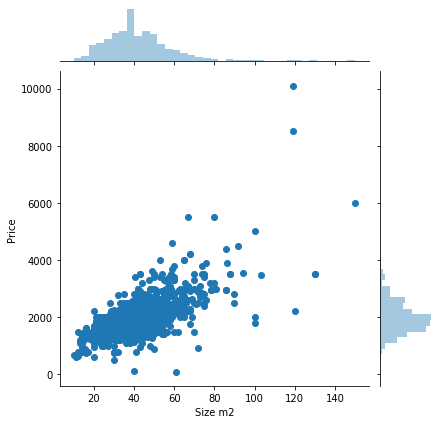

In [12]:
sns.jointplot(x='Size m2', y='Price', data=flatsOffers[['Size m2','Price']])

##### Remove the outliers

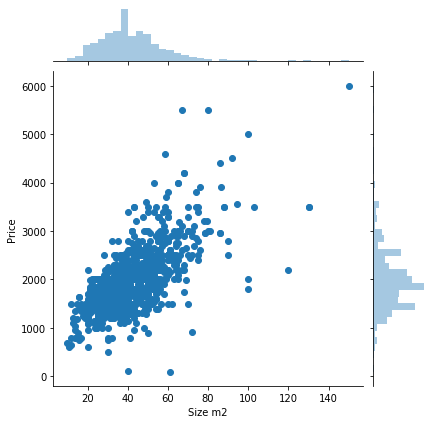

In [13]:
flatsOffers = flatsOffers[flatsOffers['Price'] <= 6000]
sns.jointplot(x='Size m2', y='Price', data=flatsOffers[['Size m2','Price']])

##### We expect the value of properties to go up as the number of rooms increases. 

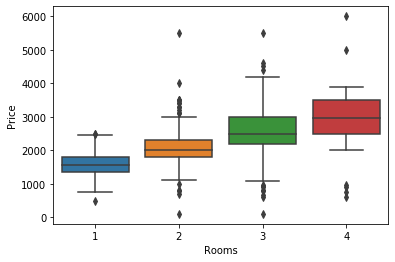

In [14]:
sns.boxplot(x='Rooms', y='Price', data=flatsOffers)

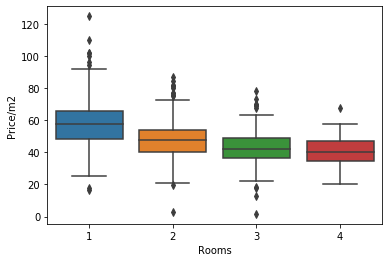

In [15]:
sns.boxplot(x='Rooms', y='Price/m2', data=flatsOffers)

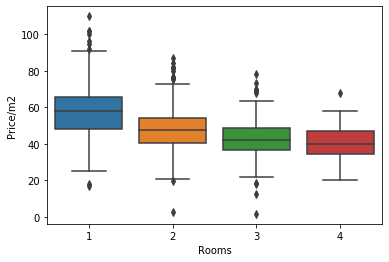

In [16]:
flatsOffers = flatsOffers[flatsOffers['Price/m2'] <= 120]
sns.boxplot(x='Rooms', y='Price/m2', data=flatsOffers)

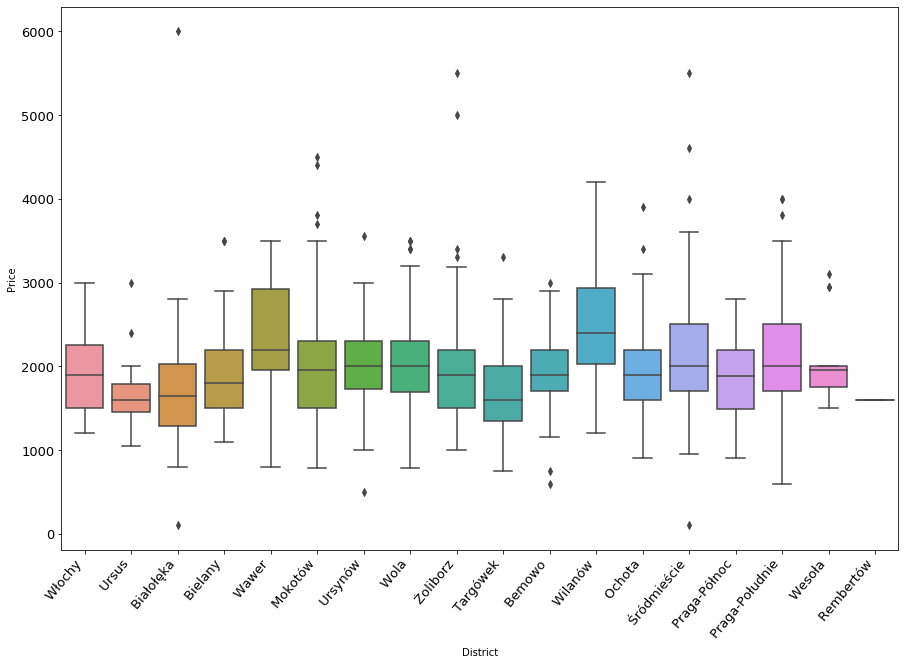

In [17]:
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='District', y='Price', data=flatsOffers)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
ax.tick_params(labelsize=13)

##### Save the dataframe to a csv file

In [18]:
flatsOffers.to_csv('flatsOffersAferProcessing.csv',index=False) 

In [19]:
flatsOffersData = pd.read_csv("flatsOffersAferProcessing.csv") 
flatsOffersData.head()

,District,Size m2,Rooms,Price,Price/m2
0,Włochy,49.00,2,2500.0,51.02
1,Ursus,37.07,2,1800.0,48.56
2,Białołęka,37.00,2,2300.0,62.16
3,Bielany,88.00,4,3499.0,39.76
4,Wawer,130.00,3,3500.0,26.92


### 3. Get coordinates for each district
##### Districts coordinates will be taken from Wikipedia

In [20]:
warsawDistricts = flatsOffersData[['District']].drop_duplicates().sort_values('District').reset_index(drop=True)

In [21]:
wp.set_lang("pl")
html = wp.page("Warszawa").html()
warsawBoroughWiki = pd.read_html(html)[16]
warsawBoroughWiki

,Dzielnica,Liczba mieszkańców(1.01.2020)[1],Gęstość zaludnienia[osób/km²](1.01.2020)[1],Powierzchnia[km²](1.01.2020)[1]
0,Mokotów,218 265,6162,3542
1,Praga-Południe,180 789,8078,2238
2,Ursynów,151 304,3455,4379
3,Wola,141 407,7342,1926
4,Bielany,131 592,4069,3234
5,Białołęka,129 106,1768,7304
6,Bemowo,125 119,5015,2495
7,Targówek,124 992,5161,2422
8,Śródmieście,113 713,7303,1557
9,Ochota,82 484,8486,972


In [22]:
warsawBoroughWiki.columns = ('Name','Population(01/01/2020)','Population_Density(km2)','Area(km2)')
warsawBoroughWiki.insert(0, 'Borough', warsawBoroughWiki.index+1)
warsawBoroughWiki = warsawBoroughWiki.reindex(columns=['Borough','Name','Area(km2)','Population(01/01/2020)','Population_Density(km2)'])

warsawBoroughWiki

,Borough,Name,Area(km2),Population(01/01/2020),Population_Density(km2)
0,1,Mokotów,3542,218 265,6162
1,2,Praga-Południe,2238,180 789,8078
2,3,Ursynów,4379,151 304,3455
3,4,Wola,1926,141 407,7342
4,5,Bielany,3234,131 592,4069
5,6,Białołęka,7304,129 106,1768
6,7,Bemowo,2495,125 119,5015
7,8,Targówek,2422,124 992,5161
8,9,Śródmieście,1557,113 713,7303
9,10,Ochota,972,82 484,8486


In [23]:
warsawBoroughWikiData = warsawBoroughWiki
geo_list = []

for x in range(0,18):
    coordinates = ""
    if x == ( 3 or 14 or 16 ):
        page = requests.get('https://pl.wikipedia.org/wiki/'+ str(warsawBoroughWikiData.Name[x]) + '_(Warszawa)')
    elif x == 4:
        page = requests.get('https://pl.wikipedia.org/wiki/Bielany_(Warszawa)')
    elif x == 8:
        page = requests.get('https://pl.wikipedia.org/wiki/Śródmieście_(Warszawa)')
    elif x == 12:
        page = requests.get('https://pl.wikipedia.org/wiki/Ursus_(Warszawa)')
    elif x == 16:
        page = requests.get('https://pl.wikipedia.org/wiki/Wesoła_(Warszawa)')
    else:
        page = requests.get('https://pl.wikipedia.org/wiki/'+ str(warsawBoroughWikiData.Name[x]))
    el = BeautifulSoup(page.content, 'html.parser').find(id='coordinates').find('span', class_='geo-nondefault').find('span', class_='geo-dms').find('span', class_='latitude')
    coordinates = el.text
    coordinates = coordinates.replace(",",".")
    el = BeautifulSoup(page.content, 'html.parser').find(id='coordinates').find('span', class_='geo-nondefault').find('span', class_='geo-dms').find('span', class_='longitude')
    coordinates = coordinates + "; " + el.text.replace(",",".")
    geo_list.append(coordinates.split("; "))
lat, lon = zip(*geo_list)

warsawBoroughWikiData['Latitude'] = lat
warsawBoroughWikiData['Longitude'] = lon
warsawBoroughWikiData

,Borough,Name,Area(km2),Population(01/01/2020),Population_Density(km2),Latitude,Longitude
0,1,Mokotów,3542,218 265,6162,52.200000,21.016944
1,2,Praga-Południe,2238,180 789,8078,52.241728,21.083867
2,3,Ursynów,4379,151 304,3455,52.141667,21.033333
3,4,Wola,1926,141 407,7342,52.233333,20.957222
4,5,Bielany,3234,131 592,4069,52.288889,20.933889
5,6,Białołęka,7304,129 106,1768,52.328889,21.007778
6,7,Bemowo,2495,125 119,5015,52.247833,20.907000
7,8,Targówek,2422,124 992,5161,52.282778,21.064306
8,9,Śródmieście,1557,113 713,7303,52.233333,21.016667
9,10,Ochota,972,82 484,8486,52.216389,20.981111


In [24]:
warsawDistrictsCoordiates = warsawBoroughWikiData.filter(['Name','Latitude','Longitude'], axis=1)
warsawDistrictsCoordiates

,Name,Latitude,Longitude
0,Mokotów,52.200000,21.016944
1,Praga-Południe,52.241728,21.083867
2,Ursynów,52.141667,21.033333
3,Wola,52.233333,20.957222
4,Bielany,52.288889,20.933889
5,Białołęka,52.328889,21.007778
6,Bemowo,52.247833,20.907000
7,Targówek,52.282778,21.064306
8,Śródmieście,52.233333,21.016667
9,Ochota,52.216389,20.981111


##### Visualization of Warsaw districts on the map 

In [25]:
mapWarsawDistrics = folium.Map(location=[52.2297700,21.0117800], zoom_start=11)

for lat, lng, district in zip(warsawDistrictsCoordiates['Latitude'], warsawDistrictsCoordiates['Longitude'], warsawDistrictsCoordiates['Name']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mapWarsawDistrics)  
    
mapWarsawDistrics

### 4. Visualize the average price/m2 and average apartment size per district on a choropleth map

##### Warsaw districts will be taken from the geojson file 

In [26]:
with open('warszawa-dzielnice.geojson') as json_data:
    locationData = json.load(json_data)

In [27]:
for idx in range(len(locationData['features'])):
    locationData['features'][idx]['properties']['name'] = locationData['features'][idx]['properties']['name'].replace('Warsaw ','')

In [28]:
meanPerDistrict = flatsOffersData.groupby('District').mean().reset_index()
meanPerDistrict

,District,Size m2,Rooms,Price,Price/m2
0,Bemowo,42.561053,1.982456,1917.000000,47.532807
1,Białołęka,42.959615,1.884615,1732.903846,42.385192
2,Bielany,42.245763,1.864407,1918.203390,48.894746
3,Mokotów,40.866601,1.810458,2029.653595,51.910065
4,Ochota,39.357018,1.824561,1993.666667,53.979649
5,Praga-Południe,46.176136,2.238636,2085.250000,47.722614
6,Praga-Północ,35.711562,1.906250,1842.656250,53.906875
7,Rembertów,30.000000,1.000000,1600.000000,53.330000
8,Targówek,42.373810,1.880952,1717.857143,41.747381
9,Ursus,38.232571,1.914286,1646.342857,45.251714


In [29]:
meanPerDistrict["cartodb_id"] = [2,19,20,21,22,23,24,25,27,28,29,30,31,32,34,33,26,35]
meanPerDistrict

,District,Size m2,Rooms,Price,Price/m2,cartodb_id
0,Bemowo,42.561053,1.982456,1917.000000,47.532807,2
1,Białołęka,42.959615,1.884615,1732.903846,42.385192,19
2,Bielany,42.245763,1.864407,1918.203390,48.894746,20
3,Mokotów,40.866601,1.810458,2029.653595,51.910065,21
4,Ochota,39.357018,1.824561,1993.666667,53.979649,22
5,Praga-Południe,46.176136,2.238636,2085.250000,47.722614,23
6,Praga-Północ,35.711562,1.906250,1842.656250,53.906875,24
7,Rembertów,30.000000,1.000000,1600.000000,53.330000,25
8,Targówek,42.373810,1.880952,1717.857143,41.747381,27
9,Ursus,38.232571,1.914286,1646.342857,45.251714,28


##### Visualisation of average price/m2 per district

In [36]:
warsawGeo = r'warszawa-dzielnice.geojson'

# create a map of Warsaw
warsawMap = folium.Map(location=[52.2297700,21.0117800], zoom_start=10)

# add the data
folium.Choropleth(
    geo_data=warsawGeo,
    data=meanPerDistrict,
    columns=['cartodb_id', 'Price/m2'],
    key_on='feature.properties.cartodb_id',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average price/m2 for each district in Warsaw'
).add_to(warsawMap)

folium.LayerControl().add_to(warsawMap)

# add markers to map
for lat, lng, district in zip(warsawDistrictsCoordiates['Latitude'], warsawDistrictsCoordiates['Longitude'], warsawDistrictsCoordiates['Name']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=100,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(warsawMap) 

warsawMap

##### Visualisation of average apartment size per district

In [34]:
# create a map of Warsaw
warsawMap2 = folium.Map(location=[52.2297700,21.0117800], zoom_start=10)

# add the data
warsawMap2.choropleth(
    geo_data=locationData,
    data=meanPerDistrict,
    columns=['cartodb_id', 'Size m2'],
    key_on='feature.properties.cartodb_id',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average apartment size for each district in Warsaw'
)

# add markers to map
for lat, lng, district in zip(warsawDistrictsCoordiates['Latitude'], warsawDistrictsCoordiates['Longitude'], warsawDistrictsCoordiates['Name']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=100,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(warsawMap2) 

warsawMap2

### 5. Get Foursquare data

##### Foursquare Credentials

In [38]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20201214' # Foursquare API version

##### Function to repeat the same process to all the districts in Warsaw

In [39]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [40]:
warsawVenues = getNearbyVenues(names=warsawDistrictsCoordiates['Name'],
                                   latitudes=warsawDistrictsCoordiates['Latitude'],
                                   longitudes=warsawDistrictsCoordiates['Longitude'],
                                   radius=2000, LIMIT=100)

In [41]:
warsawVenues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Mokotów,52.200000,21.016944,Ciao a Tutti Due,52.201612,21.016697,Pizza Place
1,Mokotów,52.200000,21.016944,Gringo Bar Burritos Tacos & More,52.201305,21.020496,Burrito Place
2,Mokotów,52.200000,21.016944,VEGAN RAMEN SHOP VRS,52.202312,21.015183,Ramen Restaurant
3,Mokotów,52.200000,21.016944,Relaks,52.202619,21.021834,Coffee Shop
4,Mokotów,52.200000,21.016944,MEZZE hummus & falafel,52.203548,21.022705,Falafel Restaurant


In [42]:
print('{} venues are collected'.format(warsawVenues.shape[0]))

1098 venues are collected


In [43]:
warsawVenues.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Bemowo,60,60,60,60,60,60
Białołęka,12,12,12,12,12,12
Bielany,59,59,59,59,59,59
Mokotów,100,100,100,100,100,100
Ochota,100,100,100,100,100,100
Praga-Południe,77,77,77,77,77,77
Praga-Północ,100,100,100,100,100,100
Rembertów,10,10,10,10,10,10
Targówek,34,34,34,34,34,34


##### Let's find out how many unique categories can be curated from all the returned venues

In [44]:
print('There are {} uniques categories.'.format(len(warsawVenues['Venue Category'].unique())))

There are 210 uniques categories.


### 6. Warsaw districts analyze

In [45]:
# one hot encoding
warsaw_onehot = pd.get_dummies(warsawVenues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
warsaw_onehot['District'] = warsawVenues['District'] 

# move neighborhood column to the first column
fixed_columns = [warsaw_onehot.columns[-1]] + list(warsaw_onehot.columns[:-1])
warsaw_onehot = warsaw_onehot[fixed_columns]

warsaw_onehot.head()

,District,African Restaurant,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Mokotów,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Mokotów,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Mokotów,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Mokotów,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Mokotów,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Next, let's group rows by district and by taking the mean of the frequency of occurrence of each category

In [46]:
warsaw_grouped = warsaw_onehot.groupby('District').mean().reset_index()
warsaw_grouped

,District,African Restaurant,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Bemowo,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.016667,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.033333,0.00,0.00,0.00
1,Białołęka,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.083333,0.000000,...,0.000000,0.083333,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00
2,Bielany,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.016949,...,0.000000,0.000000,0.016949,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00
3,Mokotów,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.020000,0.000000,...,0.000000,0.010000,0.000000,0.000000,0.00,0.020000,0.000000,0.00,0.00,0.00
4,Ochota,0.000000,0.020000,0.00,0.00,0.00,0.000000,0.00,0.010000,0.000000,...,0.000000,0.020000,0.000000,0.000000,0.01,0.010000,0.000000,0.00,0.00,0.00
5,Praga-Południe,0.012987,0.000000,0.00,0.00,0.00,0.012987,0.00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.012987,0.00,0.000000,0.000000,0.00,0.00,0.00
6,Praga-Północ,0.000000,0.000000,0.01,0.00,0.00,0.020000,0.00,0.000000,0.010000,...,0.000000,0.010000,0.000000,0.000000,0.01,0.000000,0.000000,0.00,0.01,0.03
7,Rembertów,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00
8,Targówek,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00
9,Ursus,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,...,0.023256,0.046512,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00


##### First, let's write a function to sort the venues in descending order

In [47]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

##### Now let's create a new dataframe and display the top 10 venues for each district

In [48]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for idx in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(idx+1, indicators[idx]))
    except:
        columns.append('{}th Most Common Venue'.format(idx+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = warsaw_grouped['District']

for idx in np.arange(warsaw_grouped.shape[0]):
    district_venues_sorted.iloc[idx, 1:] = return_most_common_venues(warsaw_grouped.iloc[idx, :], num_top_venues)

In [49]:
district_venues_sorted

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bemowo,Bus Station,Coffee Shop,Supermarket,Café,Italian Restaurant,Gym,Tram Station,Pizza Place,Fast Food Restaurant,Shoe Store
1,Białołęka,Train Station,Vietnamese Restaurant,Movie Theater,Farmers Market,Outdoors & Recreation,Tram Station,Asian Restaurant,Hot Dog Joint,Flower Shop,Diner
2,Bielany,Grocery Store,Café,Gym,Bus Station,Coffee Shop,Tram Station,Bookstore,Gym / Fitness Center,Supermarket,Pizza Place
3,Mokotów,Coffee Shop,Park,Café,Theater,Ice Cream Shop,Breakfast Spot,Polish Restaurant,Italian Restaurant,Burger Joint,Dessert Shop
4,Ochota,Park,Café,Italian Restaurant,Gym / Fitness Center,Pub,Coffee Shop,Hotel,Pizza Place,Sushi Restaurant,Nightclub
5,Praga-Południe,Café,Park,Supermarket,Coffee Shop,Italian Restaurant,Pizza Place,Restaurant,Fast Food Restaurant,Bookstore,Gym / Fitness Center
6,Praga-Północ,Plaza,Café,Pizza Place,Polish Restaurant,Hotel,Coffee Shop,Bar,Italian Restaurant,Zoo Exhibit,Modern European Restaurant
7,Rembertów,Bus Station,Supermarket,Park,Café,Light Rail Station,Gym Pool,Big Box Store,Gun Range,Event Space,Exhibit
8,Targówek,Bus Station,Bus Line,Supermarket,Food & Drink Shop,Falafel Restaurant,Plaza,Pool,Convenience Store,Clothing Store,Eastern European Restaurant
9,Ursus,Park,Bus Station,Supermarket,Italian Restaurant,Train Station,Playground,Gym,Fast Food Restaurant,Vietnamese Restaurant,Hardware Store


### 7. Clustering of districts 

##### Run k-means to cluster the districts into 2 clusters. I choose k = 2

In [50]:
kclusters = 2

warsaw_grouped_clustering = warsaw_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(warsaw_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:17]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])

##### Let's create a new dataframe that includes the cluster as well as the price/m2 and the top 10 venues for each neighborhood.

In [51]:
district_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [52]:
district_venues_sorted

,Cluster Labels,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Bemowo,Bus Station,Coffee Shop,Supermarket,Café,Italian Restaurant,Gym,Tram Station,Pizza Place,Fast Food Restaurant,Shoe Store
1,1,Białołęka,Train Station,Vietnamese Restaurant,Movie Theater,Farmers Market,Outdoors & Recreation,Tram Station,Asian Restaurant,Hot Dog Joint,Flower Shop,Diner
2,1,Bielany,Grocery Store,Café,Gym,Bus Station,Coffee Shop,Tram Station,Bookstore,Gym / Fitness Center,Supermarket,Pizza Place
3,1,Mokotów,Coffee Shop,Park,Café,Theater,Ice Cream Shop,Breakfast Spot,Polish Restaurant,Italian Restaurant,Burger Joint,Dessert Shop
4,1,Ochota,Park,Café,Italian Restaurant,Gym / Fitness Center,Pub,Coffee Shop,Hotel,Pizza Place,Sushi Restaurant,Nightclub
5,1,Praga-Południe,Café,Park,Supermarket,Coffee Shop,Italian Restaurant,Pizza Place,Restaurant,Fast Food Restaurant,Bookstore,Gym / Fitness Center
6,1,Praga-Północ,Plaza,Café,Pizza Place,Polish Restaurant,Hotel,Coffee Shop,Bar,Italian Restaurant,Zoo Exhibit,Modern European Restaurant
7,1,Rembertów,Bus Station,Supermarket,Park,Café,Light Rail Station,Gym Pool,Big Box Store,Gun Range,Event Space,Exhibit
8,1,Targówek,Bus Station,Bus Line,Supermarket,Food & Drink Shop,Falafel Restaurant,Plaza,Pool,Convenience Store,Clothing Store,Eastern European Restaurant
9,1,Ursus,Park,Bus Station,Supermarket,Italian Restaurant,Train Station,Playground,Gym,Fast Food Restaurant,Vietnamese Restaurant,Hardware Store


In [53]:
warsawDistrictsCoordinates2 = warsawDistrictsCoordiates.rename(columns={"Name": "District"})
warsawDistrictsCoordinates2

,District,Latitude,Longitude
0,Mokotów,52.200000,21.016944
1,Praga-Południe,52.241728,21.083867
2,Ursynów,52.141667,21.033333
3,Wola,52.233333,20.957222
4,Bielany,52.288889,20.933889
5,Białołęka,52.328889,21.007778
6,Bemowo,52.247833,20.907000
7,Targówek,52.282778,21.064306
8,Śródmieście,52.233333,21.016667
9,Ochota,52.216389,20.981111


In [54]:
warsawDistrictsCoordinates3 = warsawDistrictsCoordinates2.sort_values(by=['District'],ignore_index=True)

In [55]:
# add price/m2 for each district
warsaw_merged = warsawDistrictsCoordinates3.join(meanPerDistrict['Price/m2'])
warsaw_merged

,District,Latitude,Longitude,Price/m2
0,Bemowo,52.247833,20.907000,47.532807
1,Białołęka,52.328889,21.007778,42.385192
2,Bielany,52.288889,20.933889,48.894746
3,Mokotów,52.200000,21.016944,51.910065
4,Ochota,52.216389,20.981111,53.979649
5,Praga-Południe,52.241728,21.083867,47.722614
6,Praga-Północ,52.254430,21.034720,53.906875
7,Rembertów,52.258889,21.161667,53.330000
8,Targówek,52.282778,21.064306,41.747381
9,Ursus,52.183333,20.883333,45.251714


In [56]:
# add latitude/longitude for each district
warsaw_merged = warsaw_merged.join(district_venues_sorted.set_index('District'), on='District')
warsaw_merged

,District,Latitude,Longitude,Price/m2,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bemowo,52.247833,20.907000,47.532807,1,Bus Station,Coffee Shop,Supermarket,Café,Italian Restaurant,Gym,Tram Station,Pizza Place,Fast Food Restaurant,Shoe Store
1,Białołęka,52.328889,21.007778,42.385192,1,Train Station,Vietnamese Restaurant,Movie Theater,Farmers Market,Outdoors & Recreation,Tram Station,Asian Restaurant,Hot Dog Joint,Flower Shop,Diner
2,Bielany,52.288889,20.933889,48.894746,1,Grocery Store,Café,Gym,Bus Station,Coffee Shop,Tram Station,Bookstore,Gym / Fitness Center,Supermarket,Pizza Place
3,Mokotów,52.200000,21.016944,51.910065,1,Coffee Shop,Park,Café,Theater,Ice Cream Shop,Breakfast Spot,Polish Restaurant,Italian Restaurant,Burger Joint,Dessert Shop
4,Ochota,52.216389,20.981111,53.979649,1,Park,Café,Italian Restaurant,Gym / Fitness Center,Pub,Coffee Shop,Hotel,Pizza Place,Sushi Restaurant,Nightclub
5,Praga-Południe,52.241728,21.083867,47.722614,1,Café,Park,Supermarket,Coffee Shop,Italian Restaurant,Pizza Place,Restaurant,Fast Food Restaurant,Bookstore,Gym / Fitness Center
6,Praga-Północ,52.254430,21.034720,53.906875,1,Plaza,Café,Pizza Place,Polish Restaurant,Hotel,Coffee Shop,Bar,Italian Restaurant,Zoo Exhibit,Modern European Restaurant
7,Rembertów,52.258889,21.161667,53.330000,1,Bus Station,Supermarket,Park,Café,Light Rail Station,Gym Pool,Big Box Store,Gun Range,Event Space,Exhibit
8,Targówek,52.282778,21.064306,41.747381,1,Bus Station,Bus Line,Supermarket,Food & Drink Shop,Falafel Restaurant,Plaza,Pool,Convenience Store,Clothing Store,Eastern European Restaurant
9,Ursus,52.183333,20.883333,45.251714,1,Park,Bus Station,Supermarket,Italian Restaurant,Train Station,Playground,Gym,Fast Food Restaurant,Vietnamese Restaurant,Hardware Store


In [57]:
warsaw_merged['Cluster Labels'].value_counts()

1    17
0     1
Name: Cluster Labels, dtype: int64

##### Finally, let's visualize the resulting clusters

In [58]:
map_clusters = folium.Map(location=[52.2297700,21.0117800], zoom_start=11)

# set colors
rainbow = ['blue', 'red']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(warsaw_merged['Latitude'], warsaw_merged['Longitude'], warsaw_merged['District'], warsaw_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 8. Examine Clusters

##### Cluster 1

In [59]:
cluster1 = warsaw_merged.loc[warsaw_merged['Cluster Labels'] == 0, warsaw_merged.columns[[0] + list(range(4, warsaw_merged.shape[1]))]]
cluster1

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Wesoła,0,Train Station,Forest,Pizza Place,Neighborhood,Park,Zoo Exhibit,Flea Market,Field,Fast Food Restaurant,Farmers Market


In [60]:
cluster2 = warsaw_merged.loc[warsaw_merged['Cluster Labels'] == 1, warsaw_merged.columns[[0] + list(range(4, warsaw_merged.shape[1]))]]
cluster2

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bemowo,1,Bus Station,Coffee Shop,Supermarket,Café,Italian Restaurant,Gym,Tram Station,Pizza Place,Fast Food Restaurant,Shoe Store
1,Białołęka,1,Train Station,Vietnamese Restaurant,Movie Theater,Farmers Market,Outdoors & Recreation,Tram Station,Asian Restaurant,Hot Dog Joint,Flower Shop,Diner
2,Bielany,1,Grocery Store,Café,Gym,Bus Station,Coffee Shop,Tram Station,Bookstore,Gym / Fitness Center,Supermarket,Pizza Place
3,Mokotów,1,Coffee Shop,Park,Café,Theater,Ice Cream Shop,Breakfast Spot,Polish Restaurant,Italian Restaurant,Burger Joint,Dessert Shop
4,Ochota,1,Park,Café,Italian Restaurant,Gym / Fitness Center,Pub,Coffee Shop,Hotel,Pizza Place,Sushi Restaurant,Nightclub
5,Praga-Południe,1,Café,Park,Supermarket,Coffee Shop,Italian Restaurant,Pizza Place,Restaurant,Fast Food Restaurant,Bookstore,Gym / Fitness Center
6,Praga-Północ,1,Plaza,Café,Pizza Place,Polish Restaurant,Hotel,Coffee Shop,Bar,Italian Restaurant,Zoo Exhibit,Modern European Restaurant
7,Rembertów,1,Bus Station,Supermarket,Park,Café,Light Rail Station,Gym Pool,Big Box Store,Gun Range,Event Space,Exhibit
8,Targówek,1,Bus Station,Bus Line,Supermarket,Food & Drink Shop,Falafel Restaurant,Plaza,Pool,Convenience Store,Clothing Store,Eastern European Restaurant
9,Ursus,1,Park,Bus Station,Supermarket,Italian Restaurant,Train Station,Playground,Gym,Fast Food Restaurant,Vietnamese Restaurant,Hardware Store


##### By analyzing the clusters we can see that cluster 1 have the most green spaces like forest and park. Is a suburban area. Cluster 2 is more urbanized.  

### 9. Final Visualization

##### With all the gathered data we can now create a choropleth map displaying the average price/m2 for each district as well as display information about the area type and top 10 locations for each district on the marker labels. With this map, one could determine for example that the 1st district is the most expensive district to live in, however by clustering we determined that there are several more similar districts where the price/m2 is significantly lower. Therefore, if someone wants to rent an apartment but cannot afford to live in the 1st district, they could look for apartments in the 10th or 11th district which is similar in venues but has much lower price for renting apartments.

In [63]:
warsaw_geo = r'warszawa-dzielnice.geojson'

# create a map of Warsaw
warsaw_map = folium.Map(location=[52.2297700,21.0117800], zoom_start=10)

# add the data
folium.Choropleth(
    geo_data=warsaw_geo,
    data=meanPerDistrict,
    columns=['cartodb_id', 'Price/m2'],
    key_on='feature.properties.cartodb_id',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average price/m2 for each district in Warsaw'
).add_to(warsaw_map)


# set colors
marker_colors = ['blue', 'red']

for idx in range(len(warsaw_merged)):
    html_label = ''
    
    lat = warsaw_merged['Latitude'].loc[idx]
    lng = warsaw_merged['Longitude'].loc[idx]
    district = warsaw_merged['District'].loc[idx]
    cluster = warsaw_merged['Cluster Labels'].loc[idx]
    average_price = warsaw_merged['Price/m2'].loc[idx]
    
    if (cluster == 0):
        area = 'Residential'
    elif (cluster == 1):
        area = 'Commercial / Touristic'
    else: area = "NA"
    
    html_label = '<h4>' + district + '</h4><h5><b> Area: </b>' + area + '</h5><h5><b> Average Price/m2: </b>' + str(average_price.round(2)) + '€ </h5><h5><b> Top 10 Venues: </b></h5><h5><ol>'
    
    for col in range(6, 14):
        html_label += '<li>' + warsaw_merged.iloc[idx, col]

    html_label += '</ol></h5>'
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=html_label,
        color=rainbow[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(warsaw_map)

warsaw_map